In [39]:
import numpy as np
import scipy.signal
from scipy import stats
import pandas as pd
import time
import re
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

from scipy.ndimage.filters import gaussian_filter

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(20,12)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

data_dir = "/home/perry/sleep/data3/"

features_window_step = 10
features_window_len = 300

def sec_to_time(s, x):
    new_sec = s + int(features_window_len / 10)
    if new_sec >= 60 * 60:
        return time.strftime('%-H:%M:%S', time.gmtime(new_sec))
    else:
        return time.strftime('%M:%S', time.gmtime(new_sec))
time_formatter = matplotlib.ticker.FuncFormatter(sec_to_time)

# Read Data Functions

In [3]:
def read_data_from_string(str, add_noise=False, flip_flex=False):
    rows = str.split('|')[4:]
    x = np.zeros((len(rows), 3))
    for i in range(len(rows)):
        x[i] = [int(val) for val in rows[i].split(',')]
        
    if flip_flex:
        x[:,0] = 640 - x[:, 0]
        
    # normalization
    x[:,0] = (x[:, 0] - 256) / 320.
    x[:,1] = x[:, 1] / 960.
    x[:,2] = x[:, 2] / 64
    
    if add_noise:
        noise = np.random.normal(0, 0.01, x.shape)
        x += noise
    
    return x

def read_data(filename, add_noise=False, flip_flex=False):
    with open(data_dir + filename, 'r') as f:
        return read_data_from_string(f.read(), add_noise, flip_flex)
    
def isNaN(x):
    return x != x 

# given a verbal reports, returns a vector of tuples (seconds, report)
def process_verbal_report(verbal_report):
    if isNaN(verbal_report):
        return []
    if verbal_report.strip().startswith("MISSING START"):
        print("\x1b[31mWARN: Missing start time, ignoring verbal reports\x1b[0m")
        return []
    parts = verbal_report.strip().split("**")
    last_time = 0
    ret = []
    for part in parts:
        match = re.match(r"(\d{1,2}):(\d{1,2})", part)
        if match:
            last_time += int(match.group(1)) * 60 + int(match.group(2))
        elif last_time:
            ret.append([last_time, part.strip()])
    return ret

def wrap_text(text, max_line_length=40):
    line_length = 0
    new_text = ""
    for i in range(len(text)):
        if line_length > max_line_length and text[i] == ' ':
            new_text += "\n"
            line_length = 0
        else:
            new_text += text[i]
            if text[i] == '\n':
                line_length = 0
            else:
                line_length += 1
    return new_text

# Heart Rate from ECG Functions

In [4]:
def find_peaks(sig, radius=3, eps=1e-4):
    """ Find local peaks. """
    if np.min(sig) == np.max(sig):
        return np.empty(0)

    peak_inds = []

    i = radius
    while i < (len(sig) - radius):
        if np.abs(sig[i] - max(sig[i - radius:i + radius])) < eps:
            peak_inds.append(i)
        i += 1
    
    averaged_peak_inds = []
    i = 0
    while i < len(peak_inds):
        j = 0
        while i + j + 1 < len(peak_inds) and (peak_inds[i + j + 1] - peak_inds[i + j]) < 2:
            j += 1
        averaged_peak_inds.append((peak_inds[i] + peak_inds[i + j]) / 2.)
        i += j + 1

    return (np.array(averaged_peak_inds))

def find_peaks2(sig, thresh=0.05):
    i = 0
    peaks = []
    while i < (len(sig) - 1):
        if sig[i + 1] - sig[i] > thresh:
            peaks.append(i)
            i += 3
        i += 1
            
    return peaks

def hr_correction(hr):
    if np.mean(hr) * 60 + 40 < 50:
        return ((((hr * 60) + 40) * 2) - 40) / 60
    else:
        return hr

# Feature Extraction Functions

In [5]:
# Uncomment and comment features here
feature_labels = [
    "Flex Mean",
    #"Flex SD",
    "Flex Diff Clipped",
    "EDA Mean",
    #"EDA SD",
    #"EDA Diffs Mean",
    #"EDA Diffs SD",
    "ECG HR (normalized)",
    "ECG RR Intervals Mean",
    #"ECG RR Intervals SD",
    #"ECG RR 2nd Order Intervals Mean",
    #"ECG RR 2nd Order Intervals SD",
    #"ECG RR 2nd Order Intervals Absolute Mean",
    #"ECG RR 2nd Order Intervals Absolute SD",
    #"ECG LF Power",
    #"ECG HF Power",
    "ECG LF / HF"
]
N_FEATURES = len(feature_labels)
def extract_features(x):
    #flex
    flex_mean = np.mean(x[:, 0])
    flex_sd = np.std(x[:, 0])
    
    # flex 2nd order
    flex_diffs = [x[i + 1, 0] - x[i, 0] for i in range(x.shape[0] - 1)]
    flex_diffs_mean = np.mean(flex_diffs)
    flex_diffs_sd = np.std(flex_diffs)
    
    flex_diffs_clipped = flex_diffs_mean * 5e3 if flex_diffs_mean > 1e-4 else 0
    flex_diffs_clipped = flex_diffs_clipped * flex_diffs_clipped
    
    # eda
    eda_mean = np.mean(x[:, 2])
    eda_sd = np.std(x[:, 2])
    
    # eda 2nd order
    eda_diffs = [x[i + 1, 2] - x[i, 2] for i in range(x.shape[0] - 1)]
    eda_diffs_mean = np.mean(eda_diffs)
    eda_diffs_sd = np.std(eda_diffs)
    
    # ecg 
    peaks = find_peaks2(x[:, 1])  
    if len(peaks):
        # RR intervals (peak intervals)
        rrs = [(peaks[i + 1] - peaks[i]) / 10. for i in range(len(peaks) - 1)]
        rr_mean = np.mean(rrs)
        rr_sd = np.std(rrs)

        hr = 60 / rr_mean
        hr_norm = (min(120, hr) - 40) / 60.

        # second order intervals
        rr_diffs = [rrs[i + 1] - rrs[i] for i in range(len(rrs) - 1)]
        rr_diffs_mean = np.mean(rr_diffs)
        rr_diffs_sd = np.std(rr_diffs)
        rr_diffs_abs_mean = np.mean(np.abs(rr_diffs))
        rr_diffs_abs_sd = np.std(np.abs(rr_diffs))
        
        rr_diffs_clipped = rr_diffs_mean * 10 if rr_diffs_mean > 0.02 else 0
        rr_diffs_clipped = rr_diffs_clipped * rr_diffs_clipped

        # power spectral density
        f_psd, psd = scipy.signal.periodogram(x[:, 1])
        psds= pd.DataFrame({'freq': f_psd, 'psd':psd})
        lf_power = np.mean(psds[(psds['freq']>0.04) & (psds['freq']<0.15)]['psd'])    
        hf_power = np.mean(psds[(psds['freq']<0.4) & (psds['freq']>0.15)]['psd']) 
        lf_power_norm = lf_power / (lf_power + hf_power)
        hf_power_norm = hf_power / (lf_power + hf_power)
        lfhf = np.log(lf_power / hf_power)
    else:
        rr_mean = 0
        rr_sd = 0

        hr = 0
        hr_norm = 0

        # second order intervals
        rr_diffs_mean = 0
        rr_diffs_sd = 0
        rr_diffs_abs_mean = 0
        rr_diffs_abs_sd = 0
        
        rr_diffs_clipped = 0

        # power spectral density
        lf_power = 0
        hf_power = 0
        lfhf = 0
        
    ret = []
    if "Flex Mean" in feature_labels:
        ret.append(flex_mean)
    if "Flex SD" in feature_labels:
        ret.append(flex_diffs_sd)
    if "Flex Diff Clipped" in feature_labels:
        ret.append(flex_diffs_clipped)
    if "EDA Mean" in feature_labels:
        ret.append(eda_mean)
    if "EDA SD" in feature_labels:
        ret.append(eda_sd)
    if "EDA Diffs Mean" in feature_labels:
        ret.append(eda_diffs_mean)
    if "EDA Diffs SD" in feature_labels:
        ret.append(eda_diffs_sd)
    if "ECG HR (normalized)" in feature_labels:
        ret.append(hr_norm)
    if "ECG RR Intervals Mean" in feature_labels:
        ret.append(rr_diffs_clipped)
    if "ECG RR Intervals SD" in feature_labels:
        ret.append(rr_sd)
    if "ECG RR 2nd Order Intervals Mean" in feature_labels:
        ret.append(rr_diffs_mean)
    if "ECG RR 2nd Order Intervals SD" in feature_labels:
        ret.append(rr_diffs_sd)
    if "ECG RR 2nd Order Intervals Absolute Mean" in feature_labels:
        ret.append(rr_diffs_abs_mean)
    if "ECG RR 2nd Order Intervals Absolute SD" in feature_labels:
        ret.append(rr_diffs_abs_sd)
    if "ECG LF Power" in feature_labels:
        ret.append(lf_power_norm)
    if "ECG HF Power" in feature_labels:
        ret.append(hf_power_norm)
    if "ECG LF / HF" in feature_labels:
        ret.append(lfhf)
        
    return ret

In [6]:
def extract_multi_features(data, x_len=150, step=30, start=0, end=None):
    if not end:
        end = data.shape[0]
    features = []
    for i in range(start, end-x_len+1, step):
        features.append(extract_features(data[i:i+x_len, ]))
    return np.array(features)

def get_baseline_features(features):
    start = 0
    end = len(features)
    if len(features) > 60:
        start = 60
        if len(features) > 120:
            end = 120
    return features[start:end, ]

In [7]:
def get_calibrated_features(features, calibration_features):
    mean_features = np.mean(calibration_features, axis=0)
    mean_features[1] = 0
    mean_features[4] = 0
    
    calibrated_features = features - mean_features
    calibrated_features[:, 0] = calibrated_features[:, 0].clip(max=0)
    calibrated_features[:, 3] = 4 * (calibrated_features[:, 3].clip(max=0) ** 2)
    #calibrated_features[:, 5] = calibrated_features[:, 5].clip(max=0)
    
    return calibrated_features

# Continuous Data Analysis

In [8]:
subjects = pd.read_csv(data_dir + "subjects.csv")

continuous = subjects[subjects["Continuous"] == "Yes"]
continuous

,Category,Subject,Name,Filename,Continuous,Verbal Report,Cleaned Verbal Report,Extra Filename Notes
0,Sleep Stim,1,Casey,Casey Asleep,Yes,**3:00**\n\nI see a tree of multiple colors......,**3:00**\n\nI see a tree of multiple colors......,Range 1:30~ left
12,Sleep Stim,14,Kathy,KathySleepTree,Yes,4:51 awake\n\n**2:00**\n5:03\nNothing\nHalfway...,\n**12:00**\nNothing\nHalfway asleep\n\n\n**3:...,NaN
13,Sleep Stim,15,Sophia,SophiaSleepNoStim,Yes,[[Wakeup Times AND Dreams:]]\n5:15 awake\n181/...,\n**7:00**\na rollercoaster of limited trees (...,NaN
14,Awake Stim,Control 1,Xiaojun,NaN,Yes,**2:00**\nNothing\n\n**3:00**\nA fake bbc docu...,**2:00**\nNothing\n\n**3:00**\nA fake bbc docu...,NaN
15,Awake Stim,Control 2,Anna,NaN,Yes,\n**2:00**\nWorried about how thoughts are bei...,\n**2:00**\nWorried about how thoughts are bei...,NaN
16,Awake Stim,Control 3,Veda,NaN,Yes,2:42\n\n**4:00**\n2:47\nchipotle lunch\n\n**3:...,**5:00**\nchipotle lunch\n\n**6:00**\nthe meet...,NaN
17,Awake Stim,Control 4,Sarah,SarahAwakeStim,Yes,\n**2:00**\ntrying to connect two architecture...,\n**2:00**\ntrying to connect two architecture...,NaN
18,Awake Stim,Control 5,Kelly G,KellyAwakeNoStim,Yes,**2:00**\ni'm thinking about an x files epidot...,**2:00**\ni'm thinking about an x files epidot...,NaN
19,Awake Stim,Control 6,Priscilla,PriscillaAWAKESTim,Yes,"**2:00**\nlunch, weather, and a memory of poly...","**2:00**\nlunch, weather, and a memory of poly...",NaN
20,Awake Stim,Control 7,Jonathan,JonathanAWAKESTim2,Yes,**2:00**\nthe moon and the MIT dome\n\n**3:00*...,**2:00**\nthe moon and the MIT dome\n\n**3:00*...,NaN


Analysis for C9 ( Awake NoStim )


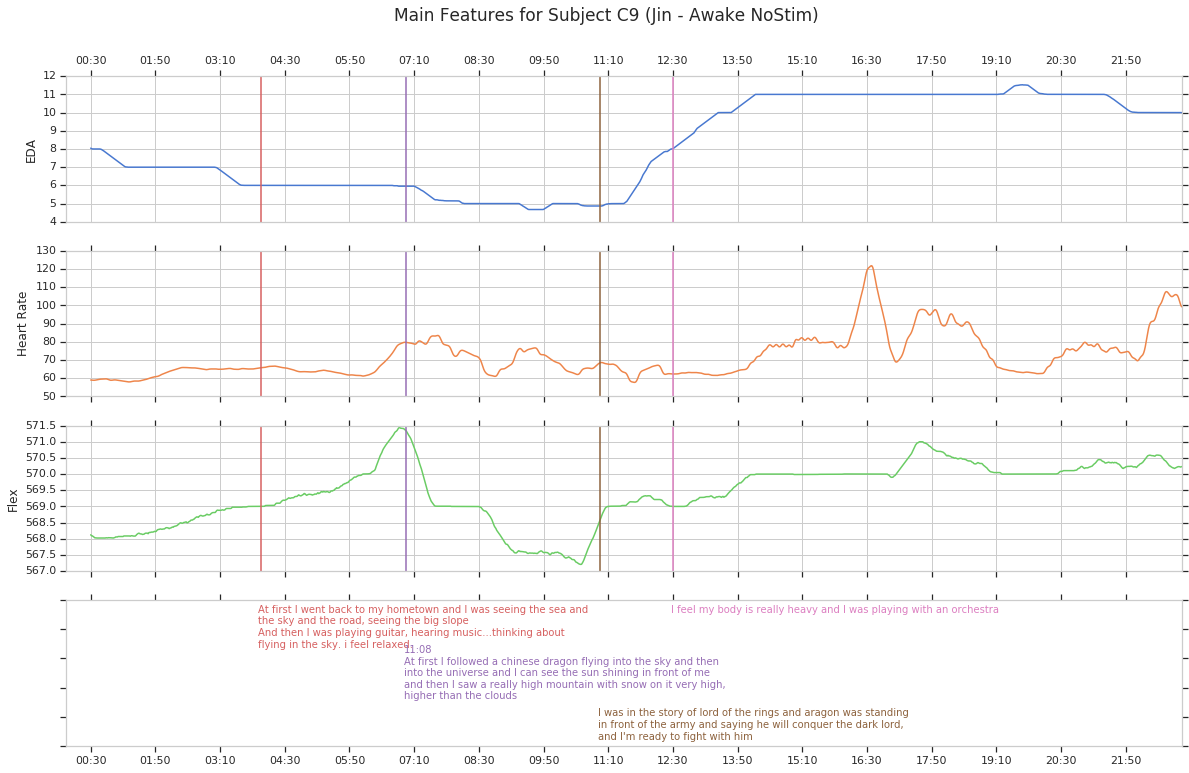

In [19]:
colors = np.concatenate([np.array(sns.color_palette("muted")), np.array(sns.color_palette("muted"))])
offset = int(features_window_len / 10)

for index, row in continuous.iterrows():
    print("Analysis for", row['Subject'], '(', row['Category'], ')')
    if isNaN(row['Filename']):
        print("\x1b[31mWARN: Missing data file, skipping!\x1b[0m")
        continue
        
    wakeups = process_verbal_report(row['Cleaned Verbal Report'])
    
    if len(wakeups) == 0:
        print("\x1b[31mWARN: Missing wakeups, skipping!\x1b[0m")
        continue
        
    try:
        data = read_data(row['Filename'])
    except:
        print("\x1b[31mWARN: Unable to read data file: %s, skipping!\x1b[0m" % row['Filename'])
        continue
    
    features = extract_multi_features(data, step=features_window_step, x_len=features_window_len)
    features[:, 3] = hr_correction(features[:, 3])
    
    f, axes = plt.subplots(4, sharex=True)
    f.suptitle("Main Features for Subject %s (%s - %s)" % (row['Subject'], row['Name'], row['Category']), fontsize=17)
    axes[0].xaxis.set_ticks_position("top")
    max_x = features.shape[0]
    if len(wakeups):
        max_x = min(wakeups[-1][0] + 600, max(max_x, wakeups[-1][0] + 60))
    for i in range(len(feature_labels)):
        if feature_labels[i] == "EDA Mean":
            x = features[:max_x, i] * 64
            axes[0].plot(x, color=colors[0])
            axes[0].set_ylabel("EDA")
            #axes[0].set_ylim(min(x[:-300]) - 5, max(x[:-300]) + 5)
        elif feature_labels[i] == "ECG HR (normalized)":
            x = gaussian_filter(features[:max_x, i], sigma=2) * 60 + 40
            axes[1].plot(x, color=colors[1])
            axes[1].set_ylabel("Heart Rate")
        elif feature_labels[i] == "Flex Mean":
            x = features[:max_x, i] * 320 + 256
            axes[2].plot(x, color=colors[2])
            axes[2].set_ylabel("Flex")
            #axes[2].set_ylim(min(x[:-300]) - 5, max(x[:-300]) + 5)
    for i in range(len(wakeups)):
        wakeup_sec, wakeup_report = wakeups[i]
        for ax in axes[:3]:
            ax.axvline(wakeup_sec - offset, color=colors[i + 3])
        wakeup_report = wrap_text(wakeup_report.strip().replace("\n\n", "\n  "), 60)
        if i % 3 == 0:
            axes[3].text(wakeup_sec - offset - 3, 
                         0.97, 
                         wakeup_report, 
                         rotation=0, 
                         ha="left", va="top", 
                         wrap=True, 
                         fontsize=10, #weight="bold",
                         color=colors[i+3])
        elif i % 3 == 1:
            axes[3].text(wakeup_sec - offset - 3, 
                         0.5, 
                         wakeup_report, 
                         rotation=0, 
                         ha="left", va="center", 
                         wrap=True, 
                         fontsize=10,  #weight="bold",
                         color=colors[i+3])
        else:
            axes[3].text(wakeup_sec - features_window_len / 10 - 3, 
                         0.03, 
                         wakeup_report, 
                         rotation=0, 
                         ha="left", va="bottom", 
                         wrap=True, 
                         fontsize=10,  #weight="bold",
                         color=colors[i+3])
    #plt.xticks([tick for tick in range(0, features.shape[0], 90)])
    for ax in axes:
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(20))
        ax.set_xlim(-offset, max_x)
    axes[3].set_yticklabels([])
    axes[3].grid(False)
    plt.gcf().axes[0].xaxis.set_major_formatter(time_formatter)
    plt.savefig('plots/%s - %s.png' % (row['Category'], row['Subject']))
    plt.show()

In [48]:
colors = np.concatenate([np.array(sns.color_palette("muted")), np.array(sns.color_palette("muted"))])
offset = int(features_window_len / 10)

eda_deltas_awake = { 0 : [], 1 : [], 2 : [] }
eda_deltas_asleep = { 0 : [], 1 : [], 2 : [] }
hr_deltas_awake = { 0 : [], 1 : [], 2 : [] }
hr_deltas_asleep = { 0 : [], 1 : [], 2 : [] }
flex_deltas_awake = { 0 : [], 1 : [], 2 : [] }
flex_deltas_asleep = { 0 : [], 1 : [], 2 : [] }

for index, row in continuous.iterrows():
    print("Analysis for", row['Subject'], '(', row['Category'], ')')
    if isNaN(row['Filename']):
        print("\x1b[31mWARN: Missing data file, skipping!\x1b[0m")
        continue
        
    wakeups = process_verbal_report(row['Cleaned Verbal Report'])
    
    if len(wakeups) == 0:
        print("\x1b[31mWARN: Missing wakeups, skipping!\x1b[0m")
        continue
        
    try:
        data = read_data(row['Filename'])
    except:
        print("\x1b[31mWARN: Unable to read data file: %s, skipping!\x1b[0m" % row['Filename'])
        continue
    
    features = extract_multi_features(data, step=features_window_step, x_len=features_window_len)
    features[:, 3] = hr_correction(features[:, 3])
    
    if len(features) < 600:
        print("Too short, skipping")
        continue
        
    calibration_average = np.mean(features[:60, 2])
    for i in range(3):
        wakeup_sec, wakeup_report = wakeups[i]
        
        wakeup_average = np.mean(features[wakeup_sec - offset - 10:wakeup_sec - offset + 10, 2])
        delta = abs(calibration_average - wakeup_average) * 64
        if row['Category'].startswith('Awake'):
            eda_deltas_awake[i].append(delta)
            print("Awake\t%d\t%.2f" % (i, delta))
        else:
            eda_deltas_asleep[i].append(delta)
            print("Asleep\t%d\t%.2f" % (i, delta))
            
    calibration_average = np.mean(features[:60, 0])
    for i in range(3):
        wakeup_sec, wakeup_report = wakeups[i]
        
        wakeup_average = np.mean(features[wakeup_sec - offset - 10:wakeup_sec - offset + 10, 0])
        
        delta = abs(calibration_average - wakeup_average) * 320
        
        if row['Category'].startswith('Awake'):
            flex_deltas_awake[i].append(delta)
            print("Awake\t%d\t%.2f" % (i, delta))
        else:
            flex_deltas_asleep[i].append(delta)
            print("Asleep\t%d\t%.2f" % (i, delta))
            
    calibration_average = np.mean(features[:60, 3])
    for i in range(3):
        wakeup_sec, wakeup_report = wakeups[i]
        
        wakeup_average = np.mean(features[wakeup_sec - offset - 10:wakeup_sec - offset + 10, 3])
        
        delta = abs(calibration_average - wakeup_average) * 60
        
        if row['Category'].startswith('Awake'):
            hr_deltas_awake[i].append(delta)
            print("Awake\t%d\t%.2f" % (i, delta))
        else:
            hr_deltas_asleep[i].append(delta)
            print("Asleep\t%d\t%.2f" % (i, delta))
    

Analysis for 1 ( Sleep Stim )
Too short, skipping
Analysis for 14 ( Sleep Stim )
Asleep	0	29.21
Asleep	1	30.20
Asleep	2	32.20
Asleep	0	12.40
Asleep	1	13.35
Asleep	2	14.37
Asleep	0	3.87
Asleep	1	2.88
Asleep	2	1.63
Analysis for 15 ( Sleep Stim )


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Asleep	0	0.51
Asleep	1	8.69
Asleep	2	9.17
Asleep	0	4.13
Asleep	1	4.09
Asleep	2	3.13
Asleep	0	0.55
Asleep	1	9.93
Asleep	2	3.36
Analysis for Control 1 ( Awake Stim )
WARN: Missing data file, skipping!
Analysis for Control 2 ( Awake Stim )
WARN: Missing data file, skipping!
Analysis for Control 3 ( Awake Stim )
WARN: Missing data file, skipping!
Analysis for Control 4 ( Awake Stim )
Awake	0	0.85
Awake	1	2.56
Awake	2	2.43
Awake	0	0.66
Awake	1	18.87
Awake	2	17.31
Awake	0	1.68
Awake	1	1.50
Awake	2	1.34
Analysis for Control 5 ( Awake Stim )
Too short, skipping
Analysis for Control 6 ( Awake Stim )
Awake	0	0.07
Awake	1	0.97
Awake	2	0.99
Awake	0	6.38
Awake	1	1.56
Awake	2	1.09
Awake	0	12.16
Awake	1	8.44
Awake	2	9.74
Analysis for Control 7 ( Awake Stim )
Awake	0	9.57
Awake	1	16.51
Awake	2	8.78
Awake	0	0.70
Awake	1	6.99
Awake	2	8.63
Awake	0	25.46
Awake	1	26.70
Awake	2	20.69
Analysis for Control 8 ( Awake Stim )
Too short, skipping
Analysis for Control 9 ( Awake Stim )
Too short, skipping
Analysis 

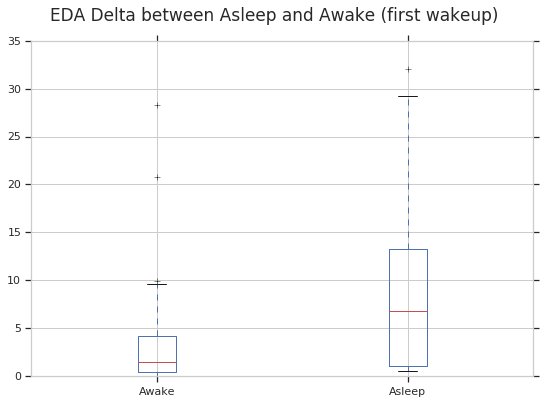

In [49]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
data_to_plot = [eda_deltas_awake[0], eda_deltas_asleep[0]] #, eda_deltas_awake[1], eda_deltas_asleep[1], eda_deltas_awake[2], eda_deltas_asleep[2]]
bp = ax.boxplot(data_to_plot)
fig.suptitle("EDA Delta between Asleep and Awake (first wakeup)", fontsize=17)
plt.xticks([1, 2], ["Awake", "Asleep"])
plt.show()

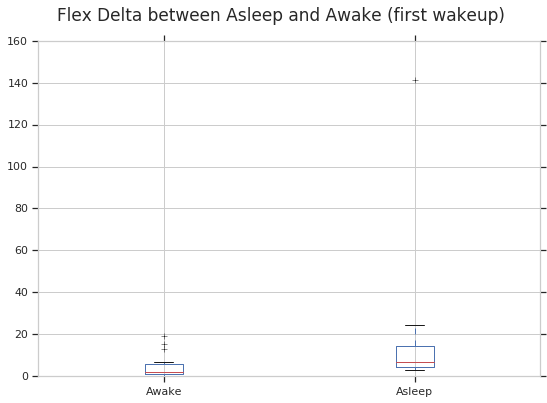

In [50]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
data_to_plot = [flex_deltas_awake[0], flex_deltas_asleep[0]] #, eda_deltas_awake[1], eda_deltas_asleep[1], eda_deltas_awake[2], eda_deltas_asleep[2]]
bp = ax.boxplot(data_to_plot)
fig.suptitle("Flex Delta between Asleep and Awake (first wakeup)", fontsize=17)
plt.xticks([1, 2], ["Awake", "Asleep"])
plt.show()

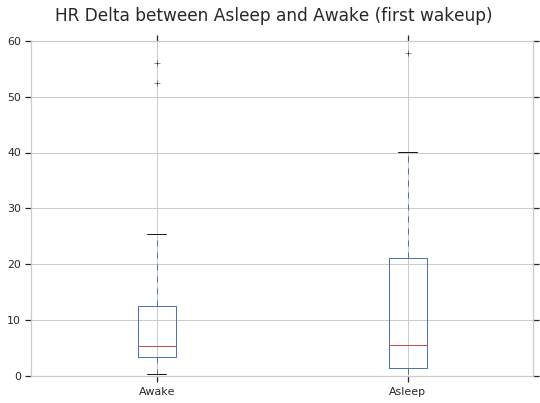

In [51]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
data_to_plot = [hr_deltas_awake[0], hr_deltas_asleep[0]] #, eda_deltas_awake[1], eda_deltas_asleep[1], eda_deltas_awake[2], eda_deltas_asleep[2]]
bp = ax.boxplot(data_to_plot)
fig.suptitle("HR Delta between Asleep and Awake (first wakeup)", fontsize=17)
plt.xticks([1, 2], ["Awake", "Asleep"])
plt.show()

In [53]:
flex_deltas_asleep[0]

[12.398111111111128,
 4.1281666666667505,
 9.128555555555664,
 2.698611111110978,
 141.56599999999992,
 4.1377777777777425,
 20.136777777777688,
 4.237499999999947,
 6.649722222222145,
 24.272500000000008,
 4.223444444444446,
 7.011888888888862]